# Clase 4. Preparación de datos. Sección 1. Preparación de datos y validación de resultados.

Este cuaderno contiene los ejemplos de la sección 2 en python/SKLearn que acompañan a la [presentación de la clase](https://docs.google.com/presentation/d/1lBF-w7pShz5fd4-LQZvsIUnHJwPomvdqlVNyKYM9Q-M/edit?usp=sharing).

**Ejemplos**

- Cómo ensayar modelos/parámetros de entrenamiento o métodos de procesamiento previo con dos esquemas de validación:
    - Cross Validation.
    - K-Fold Cross Validation.
- Presentación de resultados en diagrama Box and Whiskers.

In [1]:
%load_ext autoreload
%autoreload 2

# Importamos librerías 
import pandas as pd
import numpy as np
import sklearn
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import scipy.stats as stats

# Entrenamiento de modelos de prueba
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Evaluación de modelos de prueba
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error

# Partición de train-test set
from sklearn.model_selection import train_test_split

# Pipelines
from sklearn.pipeline import Pipeline

# Crear datasets
from sklearn.datasets import make_regression

# Esquemas de entrenamiento
from sklearn.model_selection import RepeatedStratifiedKFold, RepeatedKFold
from sklearn.model_selection import cross_val_score

np.random.seed(42)

# Versiones de librerías
print("".join(f"{x[0]}:{x[1]}\n" for x in [
    ("Pandas",pd.__version__),
    ("Numpy",np.__version__),
    ("Matplotlib",matplotlib.__version__),
    ("SKlearn",sklearn.__version__),
    ("Seaborn",sns.__version__)
]))

Pandas:0.24.2
Numpy:1.15.4
Matplotlib:3.0.3
SKlearn:0.24.1
Seaborn:0.9.0



## 1. Validación cruzada

<img src="assets/crossval.png"/>

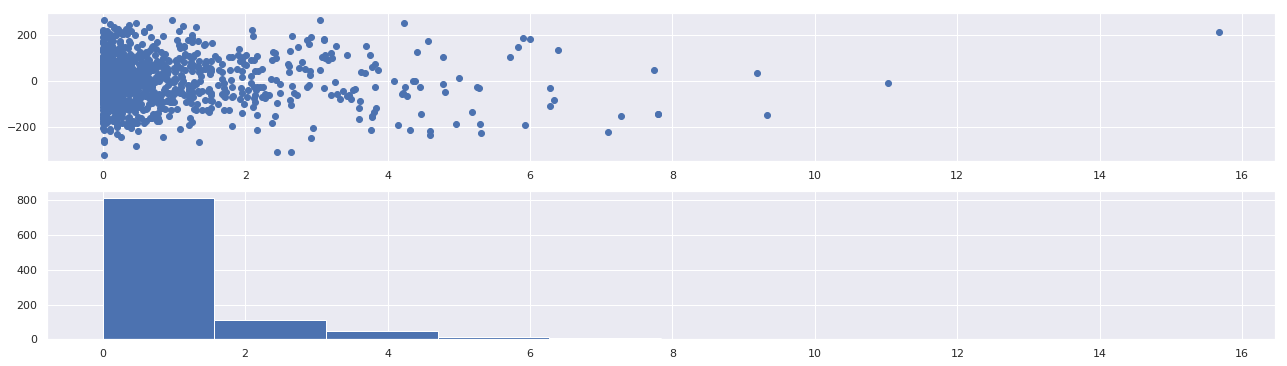

In [2]:
from sklearn.datasets import make_regression

# Creamos un dataset de prueba
X, y = make_regression(n_samples=1000, n_features=1, noise=100.0, n_informative=15, random_state=1)
X = np.square(X)
fig,axes = plt.subplots(2,figsize=(22,6))
axes[0].scatter(X,y)
axes[1].hist(X);

In [3]:
from sklearn.model_selection import train_test_split

# Particionamos en train, val, test
train_ratio = 0.70
validation_ratio = 0.20
test_ratio = 0.10

# En SKLearn no hay una función para hacer todo en un paso así que lo hacemos en 2.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=
                                                  test_ratio/(test_ratio + validation_ratio)) 
print("Train: ", X_train.shape,y_train.shape)
print("Val: ",X_val.shape,y_val.shape)
print("Test:", X_test.shape,y_test.shape)

Train:  (600, 1) (600,)
Val:  (300, 1) (300,)
Test: (100, 1) (100,)


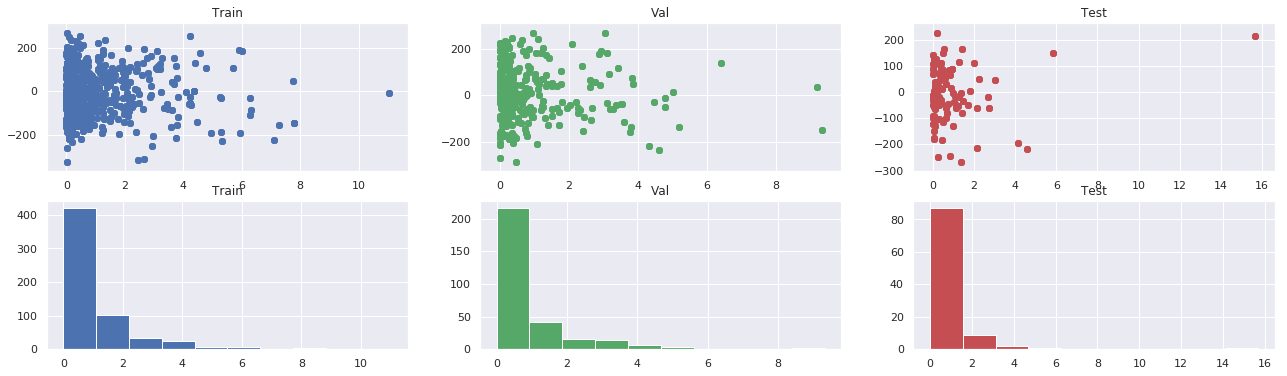

In [4]:
fig,axes = plt.subplots(2,3,figsize=(22,6))
for i in range(3):
    axes[0][0].scatter(X_train,y_train,color="b");axes[0][0].set_title("Train")
    axes[0][1].scatter(X_val,y_val,color="g");axes[0][1].set_title("Val")
    axes[0][2].scatter(X_test,y_test,color="r");axes[0][2].set_title("Test")
    axes[1][0].hist(X_train,color="b");axes[1][0].set_title("Train")
    axes[1][1].hist(X_val,color="g");axes[1][1].set_title("Val")
    axes[1][2].hist(X_test,color="r");axes[1][2].set_title("Test")

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import  mean_squared_error

# Por ahora usaremos una lista (luego reemplazaremos por Grid/Random Search)
parameters_to_test = [ 1,2,10 ]
results = []

for param in parameters_to_test:
    # Instanciar la transformación con los parámetros a ensayar
    transformer = FunctionTransformer(lambda x: np.log(x+param))  
    
    # Ajustar parámetros de la transformación sobre datos de entrenamiento
    transformer.fit(X_train)

    # Escalar entrenamiento y validación
    X_train_transformed = transformer.transform(X_train)
    X_val_transformed = transformer.transform(X_val)

    # Instanciar el model y ajustarlo a los datos transformados
    model = LinearRegression()
    model.fit(X_train_transformed,y_train)
    
    # Evaluar
    yhat = model.predict(X_val_transformed)
    mse = mean_squared_error(y_val, yhat)
    print( 'Param:', param, 'Val MSE: %.3f ' % mse)
    results.append({
        "mse": mse,
        "model": model,
        "transformer": transformer
    })

Param: 1 Val MSE: 12844.382 
Param: 2 Val MSE: 12839.005 
Param: 10 Val MSE: 12827.880 


In [6]:
best_model_idx = np.array([r['mse'] for r in results]).argmin()
print("Mejores parámetros en Validación",parameters_to_test[best_model_idx])

model = results[best_model_idx]['model']
transformer = results[best_model_idx]['transformer']
X_test_transformed = transformer.transform(X_test)
yhat = model.predict(X_test_transformed)
mse  = mean_squared_error(y_test, yhat)
print('MSE en evaluación: %.3f ' % mse)

Mejores parámetros en Validación 10
MSE en evaluación: 11291.703 


##  2 K-Fold Cross Validation

<img src="assets/kfold.png"/>

In [7]:
from sklearn.model_selection import train_test_split

# Particionamos en train, val, test
train_ratio = 0.90
test_ratio = 0.10

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio)
print("Train: ", X_train.shape,y_train.shape)
print("Test:", X_test.shape,y_test.shape)

Train:  (900, 1) (900,)
Test: (100, 1) (100,)


In [8]:
# Stratified is to ensure that each fold of dataset has the same proportion of observations with a given label.
# https://stackoverflow.com/questions/65318931/stratifiedkfold-vs-kfold-in-scikit-learn
from sklearn.model_selection import RepeatedStratifiedKFold, RepeatedKFold
from sklearn.model_selection import cross_val_score

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

parameters_to_test = [ 1,2,10 ]
results = []

for param in parameters_to_test:
    
    # Instanciar la cadena con los parámetros a ensayar
    pipeline = Pipeline(steps=[
        ('transformer', FunctionTransformer(lambda x: np.log(x+param)) ),
        ('model', LinearRegression())
    ])
    
    # 5 particiones y 5 repeticiones
    cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)
    errors = cross_val_score(pipeline, X_train, y_train, scoring= 'neg_mean_squared_error', cv=cv, n_jobs=-1)
    
    mse = np.mean(-errors)
    print( 'Params:', param, 'Val mse: %.4f ' % mse)
    results.append(
        {
            "mse": mse,
            "errors": errors
        })

Params: 1 Val mse: 11025.7881 
Params: 2 Val mse: 11027.1928 
Params: 10 Val mse: 11038.4558 


In [10]:
best_model_idx = np.array([r['mse'] for r in results]).argmin()
best_param = parameters_to_test[best_model_idx]
print("Mejores parámetros",parameters_to_test[best_model_idx])

# Instanciar la cadena con los mejores parámetros
pipeline = Pipeline(steps=[
    ('transformer', FunctionTransformer(lambda x: np.log(x+best_param)) ),
    ('model', LinearRegression())
])

pipeline.fit(X_train,y_train)
yhat = pipeline.predict(X_test)
mse  = mean_squared_error(y_test, yhat)
print('Error en evaluación: %.3f ' % mse)

Mejores parámetros 1
Error en evaluación: 14253.558 


## 3. Comparación de resultados en diagrama de Box and Whiskers

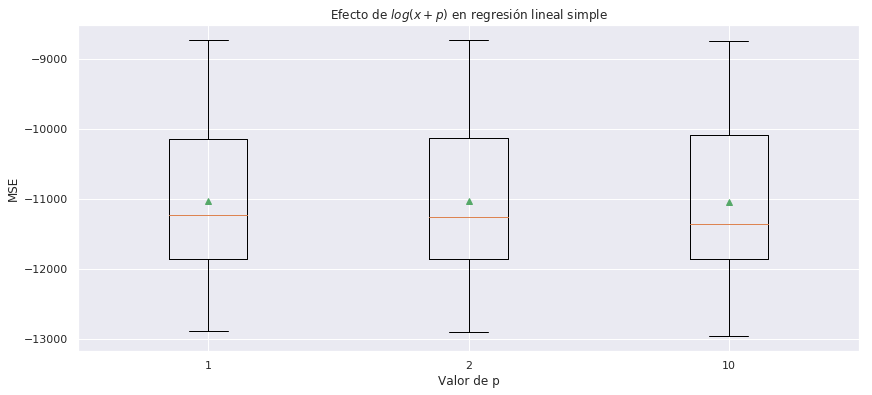

In [11]:
fig,axes = plt.subplots(1,figsize=(14,6))
axes.boxplot(np.array([r['errors'] for r in results]).T,labels=parameters_to_test,showmeans=True)
axes.set_xlabel("Valor de p")
axes.set_ylabel("MSE")
axes.set_title("Efecto de $log(x+p)$ en regresión lineal simple");